In [38]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from numpy import random
import copy
import scipy
from sko.GA import GA
from sko.PSO import PSO
from sko.DE import DE
from sko.SA import SA
from sko.SA import SAFast
from sko.AFSA import AFSA
from errorResult import MSE
from errorResult import RMSE
from errorResult import jdwucha
from errorResult import xdwucha

In [2]:
N = 6
data = np.array(pd.read_csv('dataProcess.csv',index_col = 0))
train_time = 504               #设置滑动窗口
start = 1
hour = 100   
concept = data.shape[1]

data_test = data[start+train_time:start+train_time+hour,:]     #hour做测试
data_pre = np.zeros((data_test.shape[0],data_test.shape[1]))

In [3]:
def rshape(X,N):
    W = np.zeros((N,N))  
    #lmd = temp[-N:]
    num = 0
    for i in range(N):
        for j in range(N):
            if i is not j:
                W[i,j] = X[num]
                num = num + 1
    return W

def f(x):
    y = 1/(1+np.exp(-x))
    return y

def cala(W,data,data_front,time):
    A2 = [0] * time
    A2[0] = f(np.dot(data_front,W))
    for i in range(1,time):
        A2[i] = f(np.dot(data[i-1], W))
        #A2[i + 1] = f(temp)
    return A2

def cala1(W,data):
    A2 = np.zeros(data.shape[0])
    for j in range(data.shape[0]):
        temp = np.dot(W[j],data)
        A2[j] = f(temp)
    return A2

def errorLp(X):
    W = rshape(X,N)
    A1 = cala(W,data_train,data_front,train_time)                 #更新后的矩阵
    dist = np.linalg.norm(A1 - data_train)/data_train.shape[0]        #预测矩阵与真实矩阵的欧式距离
    return dist

In [36]:
def drawPre(title,preData,realData,dataNum=10):
    plt.title(title)
    plt.plot(range(dataNum), preData, color='green', label='predict');
    plt.plot(range(dataNum), realData, color='red', label='real');
    plt.legend();
    plt.xlabel('time');
    plt.ylabel('value');
    plt.show();

def drawAll(data_pre,data_test):
    drawPre("CO",data_pre[:,0],data_test[:,0],dataNum = data_test.shape[0])
    drawPre("NO2",data_pre[:,1],data_test[:,1],dataNum = data_test.shape[0])
    drawPre("SO2",data_pre[:,2],data_test[:,2],dataNum = data_test.shape[0])
    drawPre("O3",data_pre[:,3],data_test[:,3],dataNum = data_test.shape[0])
    drawPre("PM25",data_pre[:,4],data_test[:,4],dataNum = data_test.shape[0])
    drawPre("PM10",data_pre[:,5],data_test[:,5],dataNum = data_test.shape[0])
    
def result(data_pre,data_test,path):
    path = 'error_Result/result_prediction_'+path+'.csv'
    Mwucha = MSE(data_pre,data_test)
    Rwucha = RMSE(Mwucha)
    Bm = np.linalg.norm(data_pre-data_test)/data_pre.shape[0]
    jd = jdwucha(data_pre,data_test)
    xd = xdwucha(data_pre,data_test)
    print('绝对误差：{}'.format(jd))
    print('相对误差：{}'.format(xd))
    print('欧式距离：{}'.format(Bm))
    print('MSE：{}'.format(Mwucha))
    print('RMSE:{}'.format(Rwucha))
    temp = [0]*5
    temp[0] = ["CO","NO2","SO2","O3","PM25","PM10"]
    temp[1] = jd
    temp[2] = xd
    temp[3] = Mwucha
    temp[4] = Rwucha
    temp = np.array(temp)
    temp = pd.DataFrame(temp)
    temp.to_csv(path,header=None)

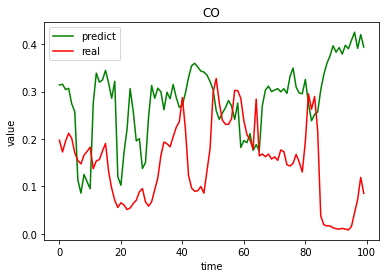

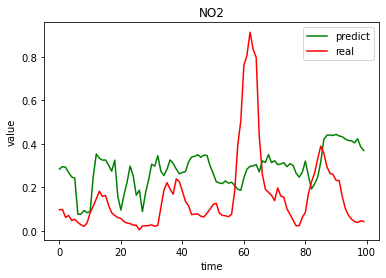

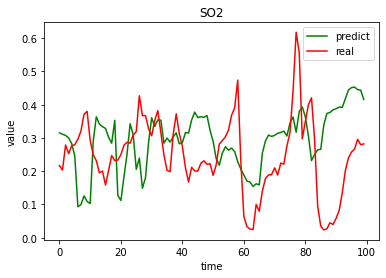

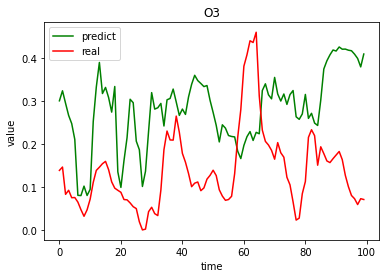

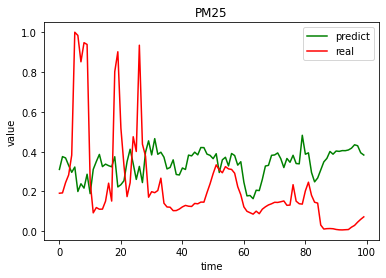

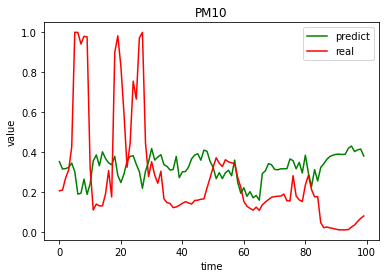

In [5]:
'''
基于实数编码遗传算法进行学习
'''
for i in range(0,hour):
    data_train = data[i+start:i+train_time+start,:]
    data_front = data[i+start-1]
    data_real = data[i+start+train_time-1,:]
    ga = GA(func=errorLp,n_dim=6*5 ,size_pop=20 , max_iter=600,lb=[-1]*5*6,ub=[1]*5*6,precision=1e-7)
    X,Y=ga.run()
    #print(X)
    W = rshape(X,N)
    data_pre[i] = cala1(W,data_real)
    #return data_pre
    
drawAll(data_pre,data_test)
result(data_pre,data_test,'ga')

In [ ]:
Y_history = pd.DataFrame(ga.all_history_Y)
fig, ax = plt.subplots(2, 1)
ax[0].plot(Y_history.index, Y_history.values, '.', color='red')
Y_history.min(axis=1).cummin().plot(kind='line')
plt.show()

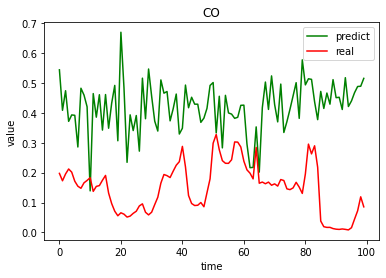

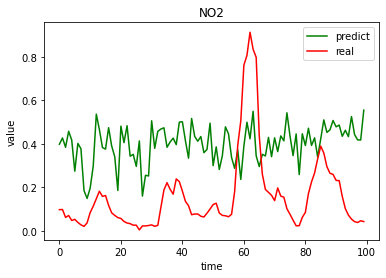

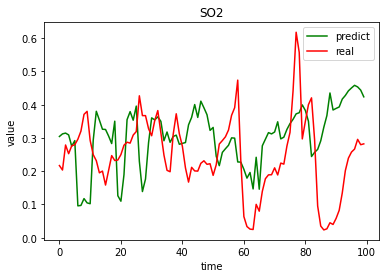

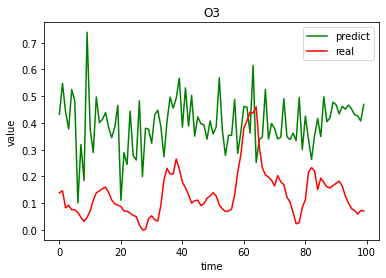

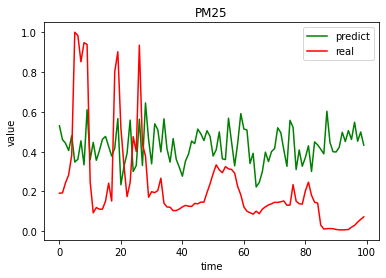

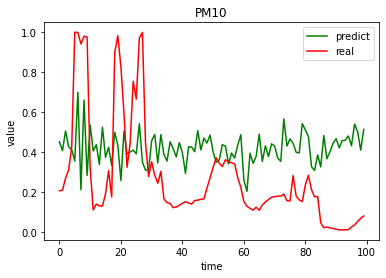

In [12]:
'''
粒子群优化算法学习
'''
for i in range(0,hour):
    data_train = data[i+start:i+train_time+start,:]
    data_front = data[i+start-1]
    data_real = data[i+start+train_time-1,:]
    pso = PSO(func=errorLp,dim=6*5 ,pop=30 , max_iter=700,lb=[-1]*5*6,ub=[1]*5*6,w=1,c1=0.5,c2=0.5)
    X,Y=pso.run()
    #print(X)
    W = rshape(X,N)
    data_pre[i] = cala1(W,data_real)
    #return data_pre
    
drawAll(data_pre,data_test)

绝对误差：[0.27070817 0.28419587 0.12920506 0.26408706 0.28583016 0.26576534]
相对误差：[5.57913775 5.46099644 1.20615233        inf 6.16063746 4.26963329]
欧式距离：0.06931815625561444
MSE：[0.08840316 0.09240882 0.02424591 0.08231288 0.09900268 0.09412723]
RMSE:[0.29732669 0.3039882  0.15571099 0.28690221 0.31464691 0.30680161]


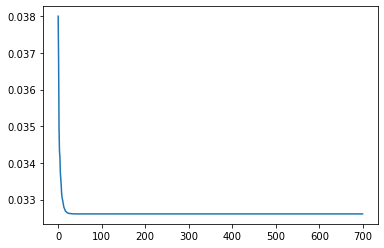

In [37]:
plt.plot(pso.gbest_y_hist)
result(data_pre,data_test,'pso')

In [ ]:
'''
差分进化学习
'''
for i in range(0,hour):
    data_train = data[i+start:i+train_time+start,:]
    data_front = data[i+start-1]
    data_real = data[i+start+train_time-1,:]
    de = DE(func=errorLp,n_dim=6*5 ,size_pop=30 , max_iter=700,lb=[-1]*5*6,ub=[1]*5*6)
    X,Y=de.run()
    #print(X)
    W = rshape(X,N)
    data_pre[i] = cala1(W,data_real)
    #return data_pre    
    
drawAll(data_pre,data_test)
result(data_pre,data_test,'de')

In [45]:
'''
模拟退火算法学习
'''
for i in range(0,hour):
    data_train = data[i+start:i+train_time+start,:]
    data_front = data[i+start-1]
    data_real = data[i+start+train_time-1,:]
    sa = SAFast(func=errorLp, L=300,q=0.99, x0=[0.5]*5*6,T_max=1,T_min=1e-9,max_stay_counter=100)
    X,Y=sa.run()
    print(Y)
    W = rshape(X,N)
    data_pre[i] = cala1(W,data_real)
    #return data_pre

<ipython-input-3-1dc780327844>:13: RuntimeWarning: overflow encountered in exp
  y = 1/(1+np.exp(-x))


0.015498823241148613
0.04489115031437477
0.02226959092014536
0.021018414972673687
0.04460210792872254
0.024715698293822648
0.02131834136370944
0.02147674349240464
0.023239882877953394
0.02179909387916798
0.032702973008186774
0.02194226562227976
0.021569345890893522
0.02187836133004837
0.02099078877658493
0.020994883362541173
0.033966257983467966
0.04473827956586526
0.03324314121875712
0.04022724938545872
0.044869050030396276
0.02167689278925108
0.02192193227424297
0.022832599277949672
0.04058337063220042
0.031824713155028134
0.02199166951623661
0.04487179641002323
0.022187062092171864
0.022285415848552575
0.0219581210726193
0.04146469984938027
0.022177164038644434
0.03503213301831285
0.02191127728510418
0.021885734647041067
0.033501309639103166
0.01705192199197046
0.03246150229161247
0.038188084159042554
0.04120014789543735
0.022350132293300427
0.03516480515355991
0.021982920029999856
0.05059360678763484
0.04384646461219486
0.05059493700634035
0.022647964052779974
0.04505435521464904
0

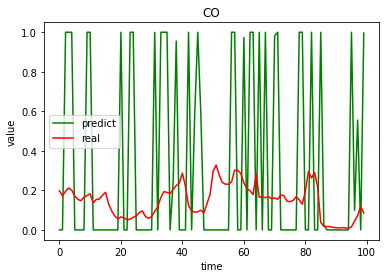

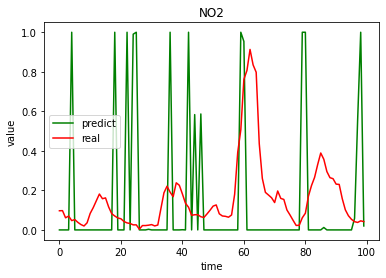

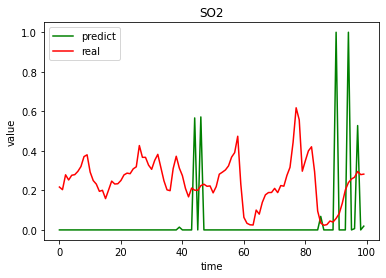

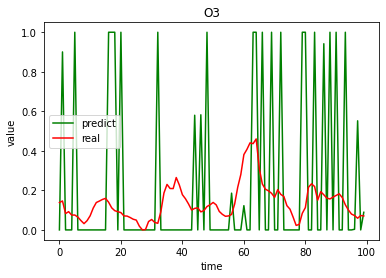

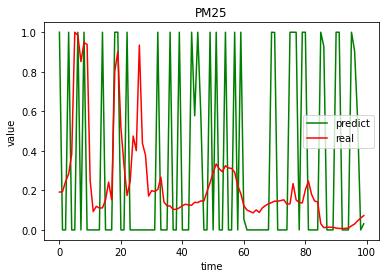

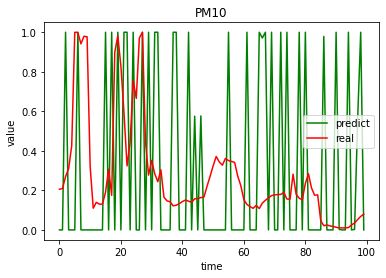

绝对误差：[0.36373288 0.253621   0.26365215 0.28001615 0.3920478  0.40854347]
相对误差：[3.44154324 3.08504941 1.18349219        nan 6.15327596 3.94306373]
欧式距离：0.10841133134073531
MSE：[0.23934361 0.14678658 0.08917707 0.16395239 0.26340748 0.27263455]
RMSE:[0.48922756 0.38312737 0.2986253  0.40491035 0.51323238 0.52214418]


E:\gitfile\FCM\errorResult.py:14: RuntimeWarning: invalid value encountered in true_divide
  dist_temp = (np.abs((data1 - data2)/data2))/(data2.shape[0])


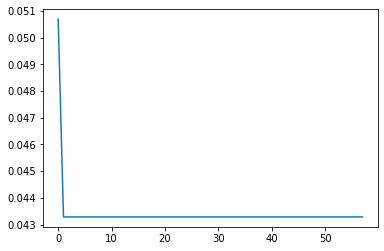

In [46]:
drawAll(data_pre,data_test)
result(data_pre,data_test,'sa')
plt.plot(pd.DataFrame(sa.best_y_history).cummin(axis=0))
plt.show()

In [ ]:
'''
人工鱼群算法学习
'''
for i in range(0,hour):
    data_train = data[i+start:i+train_time+start,:]
    data_front = data[i+start-1]
    data_real = data[i+start+train_time-1,:]
    afsa = AFSA(func=errorLp, n_dim=5*6, max_iter=300,max_try_num=100,step=0.5,visual=0.3,q=0.98,delta=0.5)
    X,Y=afsa.run()
    print(Y)
    W = rshape(X,N)
    data_pre[i] = cala1(W,data_real)
    #return data_pre
    

In [ ]:
drawAll(data_pre,data_test)
result(data_pre,data_test,'afsa')
plt.plot(pd.DataFrame(sa.best_y_history).cummin(axis=0))
plt.show()